<a href="https://colab.research.google.com/github/hwarang97/Image_classification/blob/main/VGG16_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.nn.modules.activation import Softmax
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224)
        ])
                          # 이미지, 배열을 텐서로 변경하고, 픽셀값을 정규하시켜줌
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224)
        ]) 
)

train_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.conv_relu_stack = nn.Sequential(
        nn.Conv2d(1, 64, 3, padding=1), # input 1*224*224
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1), # 1*112
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 3, padding=1), # 1*56
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(256, 512, 3, padding=1), # 1*28
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(512, 512, 3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(512, 512, 3, padding=1), # 1*14
        nn.ReLU(), 
        nn.Conv2d(512, 512, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2), # 1* 7
    )

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(7*7*512, 4096),
      nn.ReLU(),
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.Linear(1024, 10)
    )

  def forward(self, x):
    x1 = self.conv_relu_stack(x)
    x2 = self.flatten(x1)
    logits = self.linear_relu_stack(x2)
    return logits

### 사이즈 오류

- mat1 and mat2 shapes cannot be multiplied (128x400 and 784x84) 

---

- batch_size x flattend pixels, input_pixcels x output_channels

---

- 400과 input_pixcels가 동일해야함

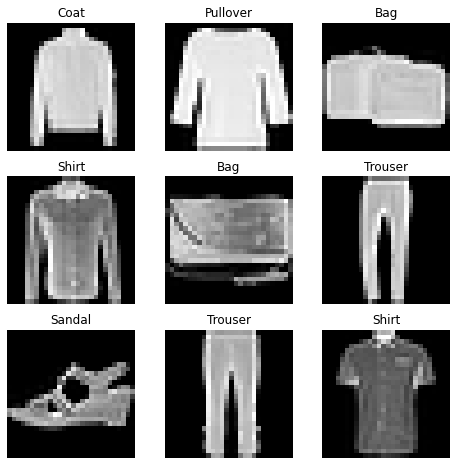

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋이 제대로 들어갔는지 시각화해서 확인

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows*cols+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # Tensor에서 값이 하나만 있는 걸 꺼낼때 사용
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off') # 축 눈금등을 없애주는 메소드, 기본값:True
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [ ]:
# 데이터 갯수 확인
len(training_data), len(test_data)

(60000, 10000)

In [ ]:
# dataloader로도 확인할 수 있음

# 방법1
print(train_dataloader.dataset, test_dataloader.dataset)

# 방법2
len(train_dataloader.dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


60000

In [ ]:
# 입력되는 이미지 크기 확인
training_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
# batch 수를 알아내는 방법 (60000 / 128 = 468.75)
len(train_dataloader)

469

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset) # train dataset size
  for batch, (X, y) in enumerate(dataloader, 1):

    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 128 * 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [ ]:
model = VGG().to(device)
print(model)

VGG(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Seq

In [ ]:
learning_rate = 1e-1
epochs = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f'Epoch {t+1}\n-----------------------------------')
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)
print('Done!!!')

Epoch 1
-----------------------------------
loss: 1.748936 [16384/60000]
loss: 0.639361 [32768/60000]
loss: 0.566938 [49152/60000]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.488340 

Epoch 2
-----------------------------------
loss: 0.414586 [16384/60000]
loss: 0.300481 [32768/60000]
loss: 0.402342 [49152/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.358915 

Epoch 3
-----------------------------------
loss: 0.352697 [16384/60000]
loss: 0.230695 [32768/60000]
loss: 0.328047 [49152/60000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.304925 

Epoch 4
-----------------------------------
loss: 0.330552 [16384/60000]
loss: 0.189240 [32768/60000]
loss: 0.264265 [49152/60000]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.276897 

Epoch 5
-----------------------------------
loss: 0.307789 [16384/60000]
loss: 0.159627 [32768/60000]
loss: 0.212876 [49152/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.271337 

Epoch 6
-----------------------------------
loss: 0.233339 [16384/60000]
loss: 0.1472

### 배치 사이즈에 따른 학습 성능

- MINST
- batch_size
  - 1 : 10epoch 기준으로 무난히 학습되며 91퍼 기록
  - 128 : 
    - 10epoch, 학습률 0.001 기준으로 학습이 거의 안됨 (5퍼 기록)
    - 30epoch, 학습률 0.001 기준으로도 학습이 거의 안됨 (11퍼 기록)
    - 15epoch, 학습률 0.1 기준으로 성능이 매우 뛰어남 (92.3퍼), 속도도 빠르고 성능도 금방 얻을 수 있었음
---
배치 사이즈가 클수록 일반적인 모델이 되며, 과적합이 일어날 수 있는것같다.

반면, 배치 사이즈가 작으면 불안정하게 수렴하게 되고 불안정한것이 노이즈가 되어 오버피팅되는것을 막는 효과를 줄 수 있다고 한다.

---
배치 사이즈가 큰데, 성능이 잘 안나온다? -> 학습률을 올려라
(참고하는 데이터가 많으니까 특출하게 오차가 많은 것들이 없어저서 조그만한 차이를 크게 볼 수 있어야한듯)

반대로 배치 사이즈가 작으면, 학습률을 낮추면 될듯

# 모델을 이어서 학습시킬 수 있다!

- 모델을 학습 시키고 나서 다시 새로 만들지 않는다면 실행버튼만 누르면 그대로 이어서 학습시킬 수 있다

# logits 값과 학습방법 정확도에 대하여

- logits란 각 클래스별 선형결과값을 모아놓은 것
  - 클래스가 10개라면 10개값이 들어있는 배열을 의미
  - batch_size가 1이라면 배열이 1개겠지만, 128개라면 128개가 있음

- 정확도
  - 지금 모델을 정확도를 계산하는 방법이 sparse_categorical일때를 가정하고 있다
  - correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  - logits들이 들어있는 pred 변수에서 가장 높은 값을 갖는 원소의 인덱스가 타켓값(정수)와 같으면 누적하는 방식이다
  - 따라서 타겟값이 정수가 아니라면 이 방법으로는 정확도를 계산할 수 없다.

- 학습
  - 모델이 확률을 반환하는 것이 아니라 logits 값을 반환하지만 학습이 되는 이유는 로스함수에서 logit 값을 입력하기 때문이다
  - 학습만을 위한다면 어떤 클래스인지 확률로 변환해서 나타내는 과정이 필요없다는 것이다.
  - 어떤 클래스를 예측했는지 예쁘게 알고싶다면 crossEntopy를 이용해서 확률로 변환하고 argmax를 통해서 어떤 클래싄지를 확인해야 한다

1. fashion MNIST로 학습 시켜서 준수한 성능 만들어내기
 - 필터 크기 5 
   - sigmoid : epoch30, l_rate:0.1, 84%
   - relu : 위와 동일 조건인데, 시작이 70퍼 이상인데?? 이게 렐루의 효과?? 89.5%
            다시 sigmoid로 확인해보자. 시그모드는 10퍼대부터 시작 ( 그러면 렐루가 100번 동안 굉장히 빠르고 급진적으로 변화를 만들어주는것 )
            학습이 진해될수록 더더지면서 90퍼이상으로는 올라가지 못함

    풀링에 따른 차이가 있는지 확인해보자
    relu, maxpoolig일때 89.7%. 맥스 풀링이 조금 더 좋은 성능을 내는것같음

 - 필터 크기 3 + 기피 하나 더 늘리기
   - relu 90 근소하게 조금 더 오르긴함


2. 이미지 크기 변환을 통해서 학습시켜보기 (최종)
  - 이미지 변환으로 일단 돌아가는지 확인 0
     성능은 91.3정도로 나옴, 근데 학습하는데 시간이 엄청 걸린다. (1시간 10분)

     오래걸린것에 비해서 성능이 비약적으로 상승하지는 않는다.

 

 logits -> 각 클래스마다의 선형 결과값을 저장
 10개 클래스면 [xxx, xxx, xxx, ... , xxx] -> 10개 묶음으로 하나를 표현

 이게 한번에 배치 사이즈만큼 출력됨

 그리고 오차를 계산해서 개선하는 방식

correct를 계산하는 방법이 이미 sparse_categorical로 가정하고 진행되는거라
내가 임의적으로 가져온 데이터셋을 사용하기 위해서는
1. sparse categorical로 변경
2. 새로운 방법 찾기



이제 문자열로 되어있는 레이블값을 어떻게 사용해서 정확도를 계산할 수 있도록 만들건지 알아봐야함

라벨과 인덱스를 매칭하는 힌트로 보이는 사이트 글
- https://blog.promedius.ai/pytorch_dataloader_1/

이미지넷 가볍게 만든 버전
- https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000